In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 22.2 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import rasterio as rio
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, UpSampling2D, concatenate, Input, BatchNormalization, Activation, Conv2DTranspose, add
from keras.optimizers import Adam, SGD, AdamW
from keras.losses import BinaryFocalCrossentropy
from keras.metrics import Precision, Recall, BinaryAccuracy
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras import backend as K
import albumentations as Album

In [ ]:
def norm_data(data):
  normalized = (data - data.min()) / (data.max() - data.min())
  return normalized

<h1> The brighter the pixel is, the higher the suitability in terms of electricity demand

Elec: [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]


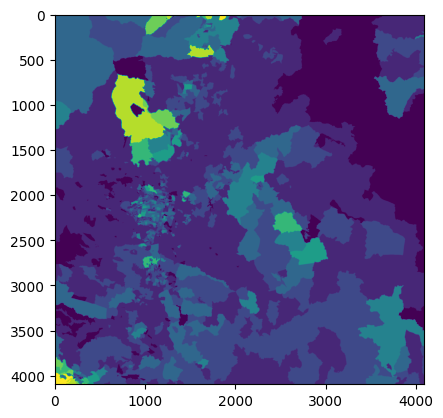

In [ ]:
elec_demand = rio.open('/content/drive/MyDrive/FYP_data/ElecDemand.tif')
elec_demand_data = elec_demand.read(1)
print("Elec:", np.unique(elec_demand_data))

plt.imshow(elec_demand_data)

<h1> The brigther pixel represent no interest spot (tourist areas), the brigther the pixel is, the more suitable it is

Interest: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


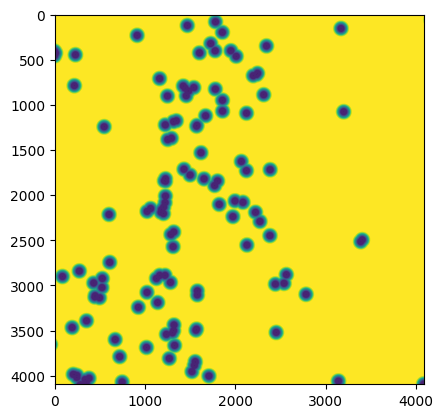

In [ ]:
Interest_spot = rio.open('/content/drive/MyDrive/FYP_data/Interest.tif')
Interest_spot_data = Interest_spot.read(1)
print("Interest:", np.unique(Interest_spot_data))

plt.imshow(Interest_spot_data)

<h1> The darker the pixel is, the more suitable it is

land price: [    0.      2733.8916  2756.6924 ... 70750.164  78718.46   79598.59  ]


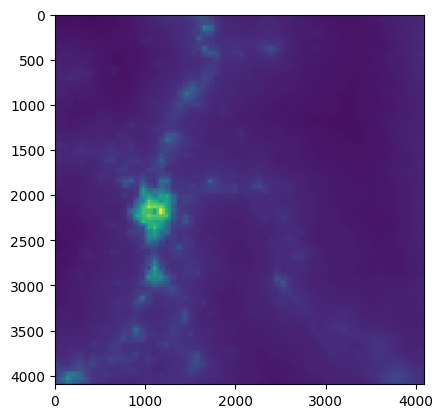

In [ ]:
Land_price = rio.open('/content/drive/MyDrive/FYP_data/LandPrice.tif')
Land_price_data = Land_price.read(1)
print("land price:", np.unique(Land_price_data))

plt.imshow(Land_price_data)

<h1> The brigther the pixel is, the more suitable it is, darker region represent natural environment

nat: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


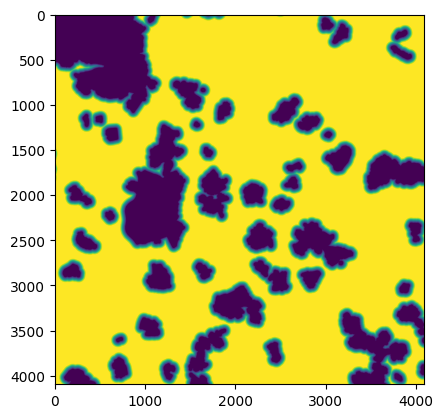

In [ ]:
Natural_environment = rio.open('/content/drive/MyDrive/FYP_data/NatEnv.tif')
Natural_environment_data = Natural_environment.read(1)
print("nat:", np.unique(Natural_environment_data))

plt.imshow(Natural_environment_data)

<h1> The brighter the pixel is, the more suitable it is.<br>
Note: wind farm is suitable to be build NEAR roads, not directly on the road itself, as a result, if we zoom in, we can see darker line within those bright pixel line

road: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


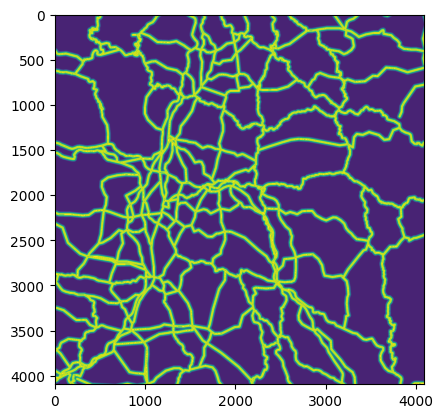

In [ ]:
Roads = rio.open('/content/drive/MyDrive/FYP_data/Road.tif')
Roads_data = Roads.read(1)
print("road:", np.unique(Roads_data))

plt.imshow(Roads_data)

<h1> The brighter the pixel is, the more suitable the steepness is for wind farm


Slope: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


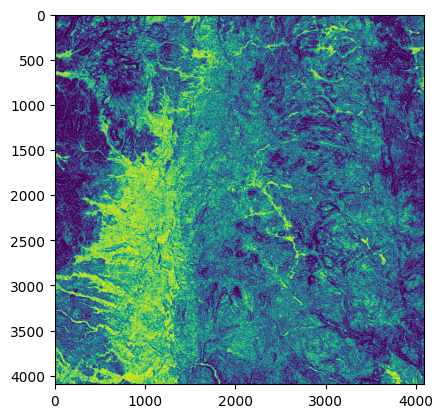

In [ ]:
Slope = rio.open('/content/drive/MyDrive/FYP_data/Slope.tif')
Slope_data = Slope.read(1)
Slope_data = Slope_data.astype(np.float32)
print("Slope:", np.unique(Slope_data))

plt.imshow(Slope_data)

<h1> The brighter the pixel is, the more suitable it is.<br>
Note: same as roads, its suitable NEAR transmission line, but unsuitable if its ON transmission line or too far away from it

transmi: [ 0.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


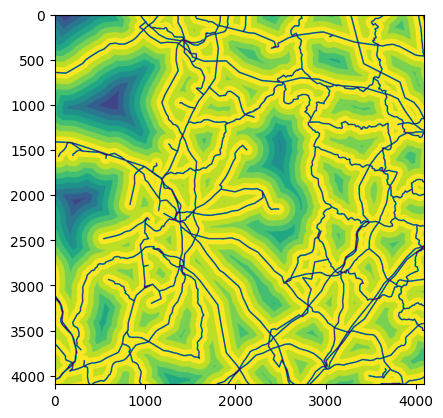

In [ ]:
Transmission_line = rio.open('/content/drive/MyDrive/FYP_data/TransmissionLine.tif')
Transmission_line_data = Transmission_line.read(1)
print("transmi:",np.unique(Transmission_line_data))

plt.imshow(Transmission_line_data)

<h1> The brighter the pixel is, the more suitable it is. Bright pixel measn no urban area

urban: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


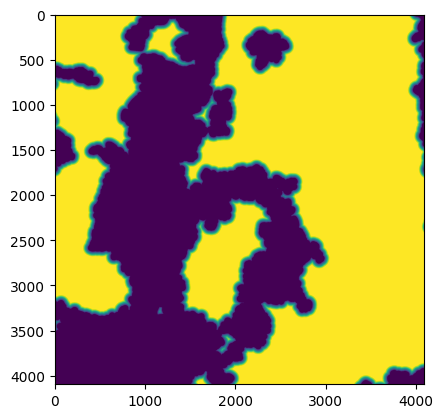

In [ ]:
Urban_area = rio.open('/content/drive/MyDrive/FYP_data/Urban.tif')
Urban_area_data = Urban_area.read(1)
print("urban:", np.unique(Urban_area_data))

plt.imshow(Urban_area_data)

<h1> The brighter the pixel is, the higher the wind speed

In [ ]:
Wind_speed = rio.open('/content/drive/MyDrive/FYP_data/Wind.tif')
Wind_speed_data = Wind_speed.read(1)
print("wind:", np.unique(Wind_speed_data))

plt.imshow(Wind_speed_data)

wind: [ 0.  2.  4.  6.  8. 10.]


[0. 1.]
(4096, 4096, 1)


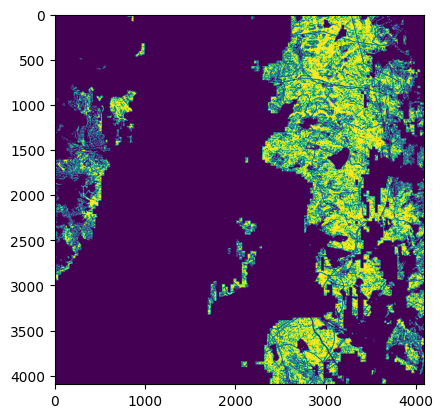

In [ ]:
#Prepare output data, the result
result_im = rio.open('/content/drive/MyDrive/FYP_data/Result.tif')
result_data = result_im.read(1)
result_data = norm_data(result_data)
print(np.unique(result_data))
result_data = np.expand_dims(result_data, axis=-1)

plt.imshow(result_data)
print(result_data.shape)


In [ ]:
elec_demand_data = norm_data(elec_demand_data)
Interest_spot_data = norm_data(Interest_spot_data)
Land_price_data = norm_data(Land_price_data)
Natural_environment_data = norm_data(Natural_environment_data)
Roads_data = norm_data(Roads_data)
Slope_data = norm_data(Slope_data)
Transmission_line_data = norm_data(Transmission_line_data)
Urban_area_data = norm_data(Urban_area_data)
Wind_speed_data = norm_data(Wind_speed_data)

input_data = np.stack((elec_demand_data, Interest_spot_data, Land_price_data,
                        Natural_environment_data, Roads_data, Slope_data,
                        Transmission_line_data, Urban_area_data, Wind_speed_data), axis=-1)
print(input_data.shape)

(4096, 4096, 9)


In [ ]:
# Reshape the array to make the 256x256 blocks apparent
new_shape = (4096 // 256, 256, 4096 // 256, 256, 9)
array_reshaped = input_data.reshape(new_shape)

# Swap the axes to make the array splitable into the blocks
array_swapped = array_reshaped.swapaxes(1, 2)

# Finally, create the blocks
input_data_array = array_swapped.reshape(-1, 256, 256, 9)
input_data_array.shape

(256, 256, 256, 9)

In [ ]:
# Reshape the array to make the 256x256 blocks apparent
new_shape = (4096 // 256, 256, 4096 // 256, 256, 1)
array_reshaped = result_data.reshape(new_shape)

# Swap the axes to make the array splitable into the blocks
array_swapped = array_reshaped.swapaxes(1, 2)

# Finally, create the blocks
result_data_array = array_swapped.reshape(-1, 256, 256, 1)
result_data_array.shape

(256, 256, 256, 1)

# However, there seems to be a class imbalance problem. The original 4096 by4096 ground truth image seems to have 80% of black pixel

In [ ]:
def find_category_index(mask_array):
  cat1_indices = []
  cat2_indices = []
  cat3_indices = []
  for i in range(mask_array.shape[0]):
    num_ones = np.count_nonzero(mask_array[i])
    num_zeros = mask_array[i].size - num_ones
    black_pixel_percentage = num_zeros / (num_ones + num_zeros)
    if black_pixel_percentage >= 0.95:
      cat1_indices.append(i)
    elif black_pixel_percentage >= 0.51:
      cat2_indices.append(i)
    else:
      cat3_indices.append(i)
  return cat1_indices, cat2_indices, cat3_indices

In [ ]:
cat1_indices, cat2_indices, cat3_indices = find_category_index(result_data_array)
print(len(cat1_indices))
print(len(cat2_indices))
print(len(cat3_indices))

134
76
46


In [ ]:
# Duplicate all 46 images whose ground truth binary mask has <=50% of black pixel (Category 3)
# Then apply data augmentation to these new bunch, then add back to original dataset

transform = Album.Compose([
    Album.HorizontalFlip(p=0.5),
    Album.VerticalFlip(p=0.5),
    ], additional_targets={'mask': 'image'})

def augment_and_show(image, mask, transform):
    augmented = transform(image=image, mask=mask)
    image_aug, mask_aug = augmented['image'], augmented['mask']
    return image_aug, mask_aug

cat3_input_array = input_data_array[cat3_indices]
cat3_mask_array = result_data_array[cat3_indices]

aug_image = []
aug_mask = []

for img, msk in zip(cat3_input_array,cat3_mask_array):
  aug_img, aug_msk = augment_and_show(img, msk, transform)
  aug_image.append(aug_img)
  aug_mask.append(aug_msk)

#Turn them to numpy array
aug_image = np.array(aug_image)
aug_mask = np.array(aug_mask)

#Concatenate back to datasets
input_data_array = np.concatenate((input_data_array, aug_image), axis = 0)
result_data_array = np.concatenate((result_data_array, aug_mask), axis = 0)





In [ ]:
print("The shape of input array after adding newly augmented data: ", input_data_array.shape)
print("The shape of mask array after adding newly augmented data: ", result_data_array.shape)
cat1_indices, cat2_indices, cat3_indices = find_category_index(result_data_array)
print("The num of cat1 after addition: ", len(cat1_indices))
print("The num of cat2 after addition: ", len(cat2_indices))
print("The num of cat3 after addition: ", len(cat3_indices))

The shape of input array after adding newly augmented data:  (302, 256, 256, 9)
The shape of mask array after adding newly augmented data:  (302, 256, 256, 1)
The num of cat1 after addition:  134
The num of cat2 after addition:  76
The num of cat3 after addition:  92


<h1> Sanity check

In [ ]:
def sanity_check(input_patch, mask_patch, i):

    plt.figure(figsize=(12, 10))

    plt.subplot(3, 4, 1)
    plt.imshow(input_patch[i, :, :, 0] , cmap='gray')  # Display the first channel of the test image
    plt.title('Elec_demand')
    plt.axis('off')

    plt.subplot(3, 4, 2)
    plt.imshow(input_patch[i, :, :, 1] , cmap='gray')  # Display the first channel of the test image
    plt.title('Interest_spot')
    plt.axis('off')

    plt.subplot(3, 4, 3)
    plt.imshow(input_patch[i, :, :, 2] , cmap='gray')  # Display the first channel of the test image
    plt.title('land_pirce')
    plt.axis('off')

    plt.subplot(3, 4, 4)
    plt.imshow(input_patch[i, :, :, 3] , cmap='gray')  # Display the first channel of the test image
    plt.title('nat_env')
    plt.axis('off')

    plt.subplot(3, 4, 5)
    plt.imshow(input_patch[i, :, :, 4] , cmap='gray')  # Display the first channel of the test image
    plt.title('roads')
    plt.axis('off')

    plt.subplot(3, 4, 6)
    plt.imshow(input_patch[i, :, :, 5] , cmap='gray')  # Display the first channel of the test image
    plt.title('Slope')
    plt.axis('off')

    plt.subplot(3, 4, 7)
    plt.imshow(input_patch[i, :, :, 6] , cmap='gray')  # Display the first channel of the test image
    plt.title('trans_line')
    plt.axis('off')

    plt.subplot(3, 4, 8)
    plt.imshow(input_patch[i, :, :, 7] , cmap='gray')  # Display the first channel of the test image
    plt.title('urban')
    plt.axis('off')

    plt.subplot(3, 4, 9)
    plt.imshow(input_patch[i, :, :, 8] , cmap='gray')  # Display the first channel of the test image
    plt.title('wind_speed')
    plt.axis('off')

    plt.subplot(3, 4, 10)
    plt.imshow(mask_patch[i, :, :, 0] , cmap='gray')
    plt.title('Ground Truth')
    plt.axis('off')


    plt.show()


In [ ]:
sanity_check(input_data_array, result_data_array, 10)

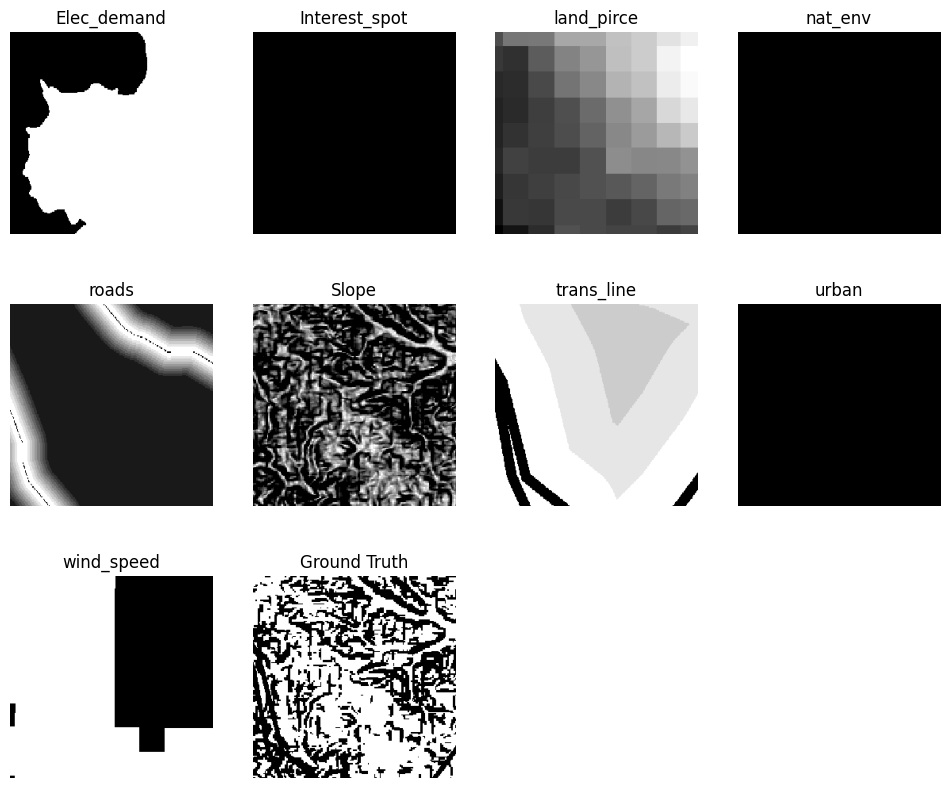

In [ ]:
sanity_check(input_data_array, result_data_array, 250)

In [ ]:
sanity_check(input_data_array, result_data_array, 230)

In [ ]:
x_train_val, x_test, y_train_val, y_test = train_test_split(input_data_array, result_data_array, test_size=0.1, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.2222, random_state=42)

In [ ]:
print(x_test[0].shape)

(256, 256, 9)


In [ ]:
def IntersectionOverUnion(y_true, y_pred, smooth=1e-6):
  Intersection = K.sum(y_true * y_pred)
  union = K.sum(y_true) + K.sum(y_pred) - Intersection
  iou = (Intersection + smooth) / (union + smooth)
  return iou

def DiceCoefficient(y_true, y_pred, smooth=1e-6):
  intersection = K.sum(y_true * y_pred)
  return (2 * intersection + smooth) / (K.sum(y_true) + K.sum(y_pred) + smooth)

In [ ]:
def unet_model_with_bn(input_size=(256, 256, 9)):
    inputs = Input(input_size)

    # Contracting Path
    c1 = Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    c1 = Activation('relu')(c1)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same')(c1)
    c1 = BatchNormalization()(c1)
    c1 = Activation('relu')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(64, (3, 3), kernel_initializer='he_normal', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Activation('relu')(c2)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(64, (3, 3), kernel_initializer='he_normal', padding='same')(c2)
    c2 = BatchNormalization()(c2)
    c2 = Activation('relu')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    # Bottleneck
    c3 = Conv2D(128, (3, 3), kernel_initializer='he_normal', padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Activation('relu')(c3)
    c3 = Dropout(0.1)(c3)
    c3 = Conv2D(128, (3, 3), kernel_initializer='he_normal', padding='same')(c3)
    c3 = BatchNormalization()(c3)
    c3 = Activation('relu')(c3)

    # Expansive Path
    u4 = Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(c3)
    u4 = concatenate([u4, c2], axis=3)
    c4 = Conv2D(64, (3, 3), kernel_initializer='he_normal', padding='same')(u4)
    c4 = BatchNormalization()(c4)
    c4 = Activation('relu')(c4)
    c4 = Dropout(0.1)(c4)
    c4 = Conv2D(64, (3, 3), kernel_initializer='he_normal', padding='same')(c4)
    c4 = BatchNormalization()(c4)
    c4 = Activation('relu')(c4)

    u5 = Conv2DTranspose(32, (2,2), strides=(2,2), padding='same')(c4)
    u5 = concatenate([u5, c1], axis=3)
    c5 = Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same')(u5)
    c5 = BatchNormalization()(c5)
    c5 = Activation('relu')(c5)
    c5 = Dropout(0.1)(c5)
    c5 = Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same')(c5)
    c5 = BatchNormalization()(c5)
    c5 = Activation('relu')(c5)

    # Output layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(c5)

    model = Model(inputs=[inputs], outputs=[outputs])

    #model.summary()

    return model


In [ ]:
model = unet_model_with_bn()
model.compile(optimizer=Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=['accuracy', IntersectionOverUnion, DiceCoefficient])


In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(x_train, y_train, batch_size=32, epochs=50, callbacks=[reduce_lr],
                    validation_data=(x_val, y_val))

Epoch 1/50
7/7 [==============================] - 56s 4s/step - loss: 0.5149 - accuracy: 0.7495 - IntersectionOverUnion: 0.2026 - DiceCoefficient: 0.3358 - val_loss: 0.6193 - val_accuracy: 0.6703 - val_IntersectionOverUnion: 0.2402 - val_DiceCoefficient: 0.3872 - lr: 1.0000e-04
Epoch 2/50
7/7 [==============================] - 6s 824ms/step - loss: 0.4379 - accuracy: 0.8001 - IntersectionOverUnion: 0.2625 - DiceCoefficient: 0.4152 - val_loss: 0.6042 - val_accuracy: 0.6830 - val_IntersectionOverUnion: 0.2582 - val_DiceCoefficient: 0.4102 - lr: 1.0000e-04
Epoch 3/50
7/7 [==============================] - 5s 785ms/step - loss: 0.3877 - accuracy: 0.8411 - IntersectionOverUnion: 0.3174 - DiceCoefficient: 0.4805 - val_loss: 0.5960 - val_accuracy: 0.6743 - val_IntersectionOverUnion: 0.2776 - val_DiceCoefficient: 0.4343 - lr: 1.0000e-04
Epoch 4/50
7/7 [==============================] - 5s 779ms/step - loss: 0.3527 - accuracy: 0.8598 - IntersectionOverUnion: 0.3607 - DiceCoefficient: 0.5287 - v

In [ ]:
predictions = model.predict(x_test)

1/1 [==============================] - 7s 7s/step


In [ ]:
threshold_pred = (predictions > 0.5).astype('float32')

In [ ]:
print("x_test shape: ", x_test.shape)
print("y_test shape: ", y_test.shape)
print("prediction shape: ", predictions.shape)


x_test shape:  (31, 256, 256, 9)
y_test shape:  (31, 256, 256, 1)
prediction shape:  (31, 256, 256, 1)


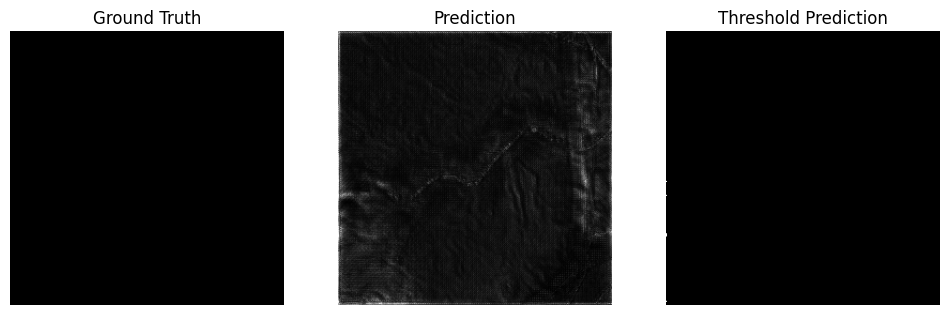

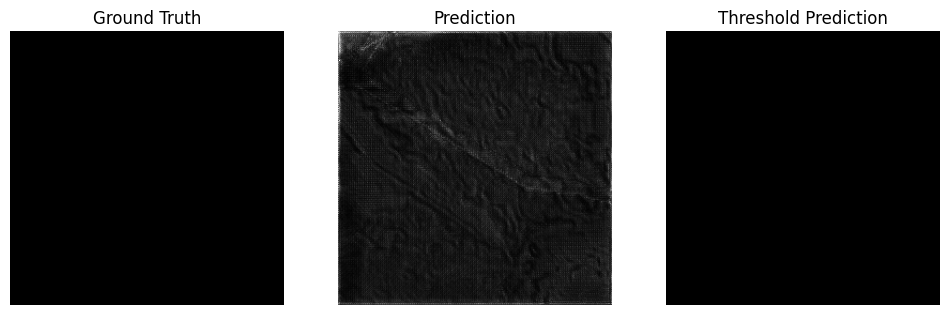

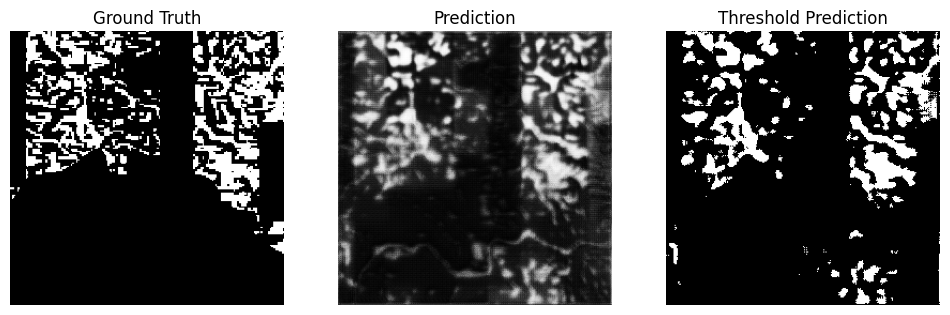

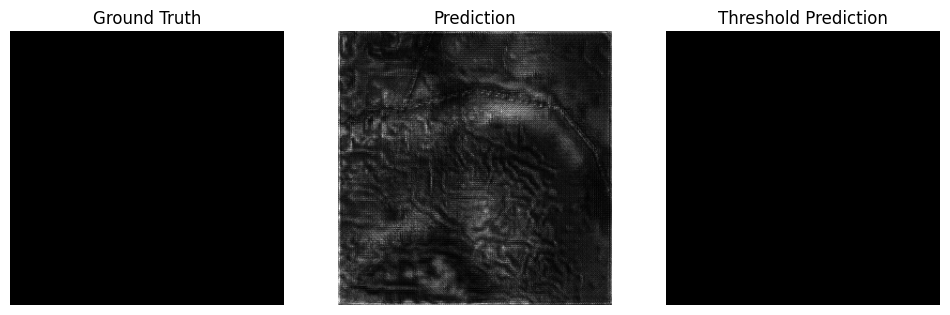

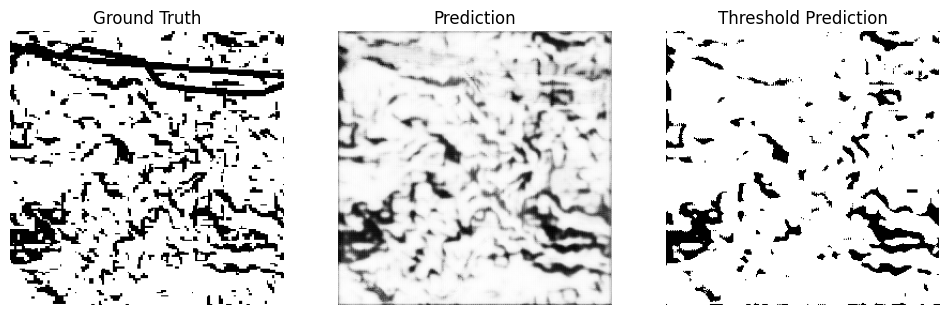

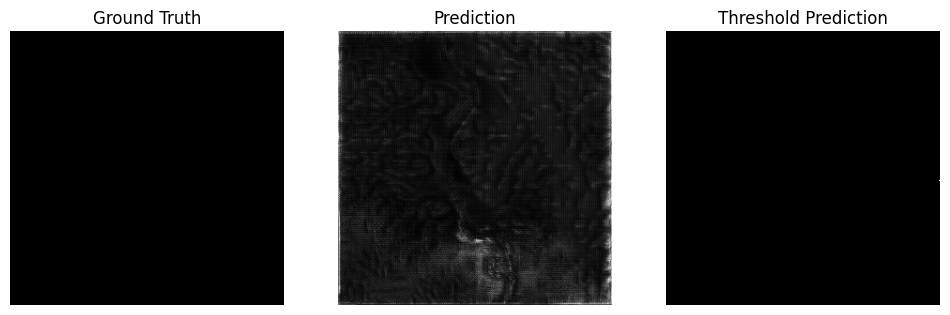

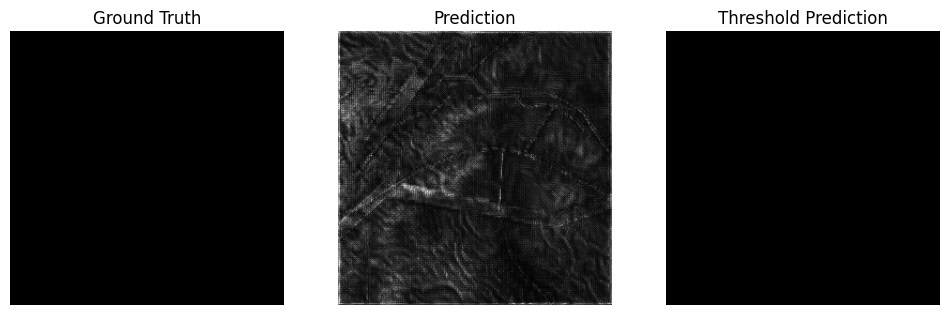

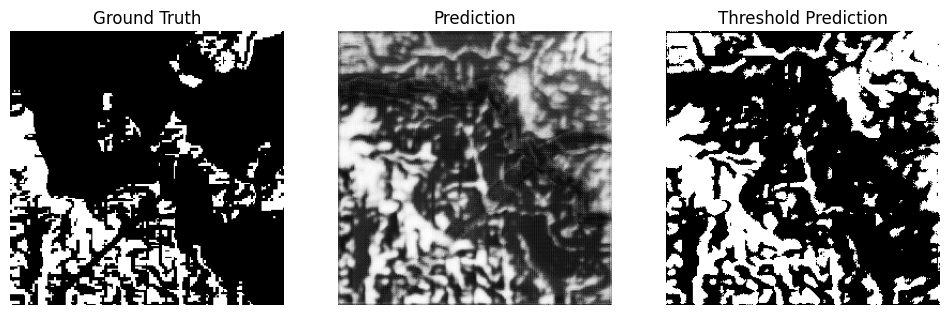

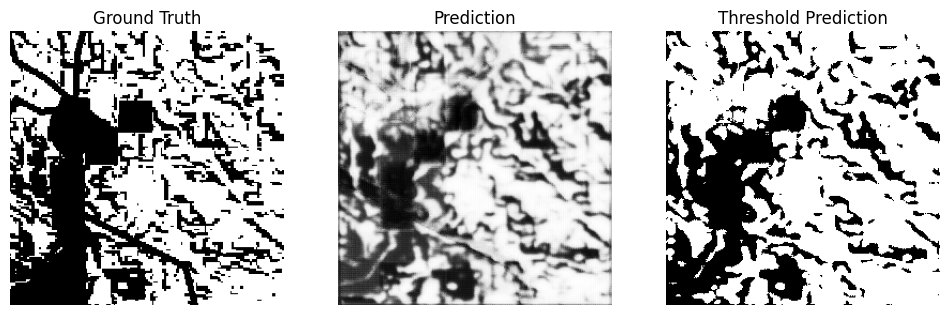

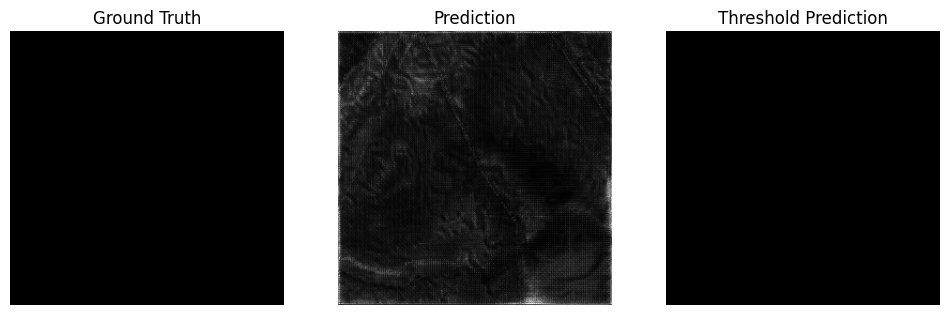

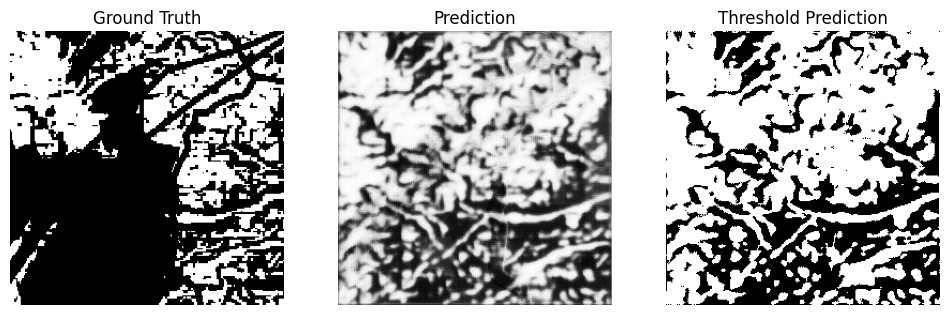

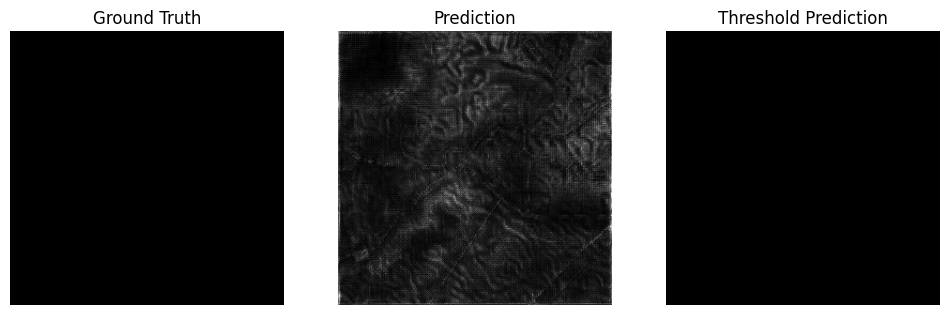

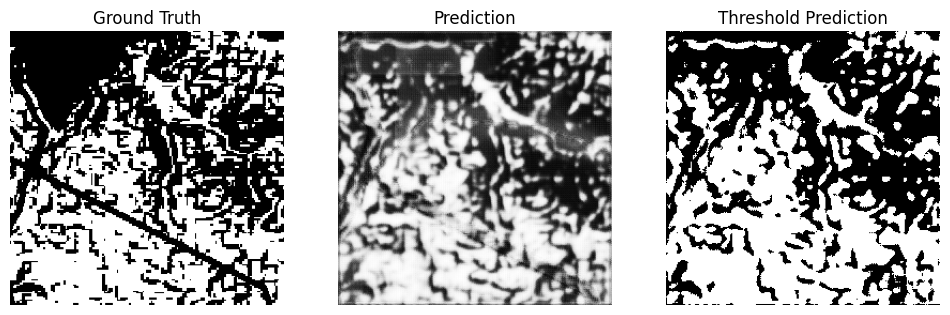

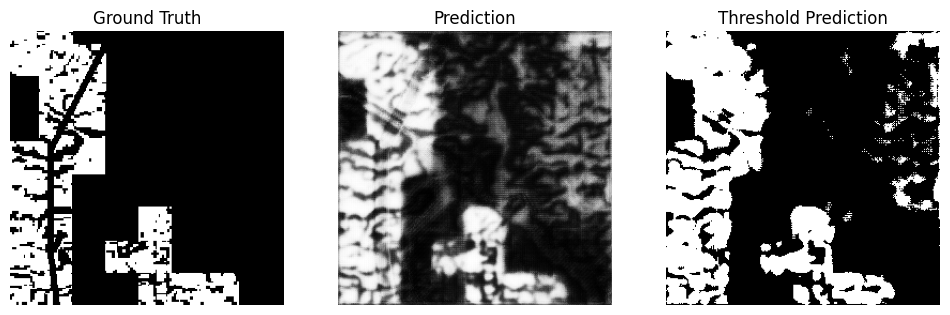

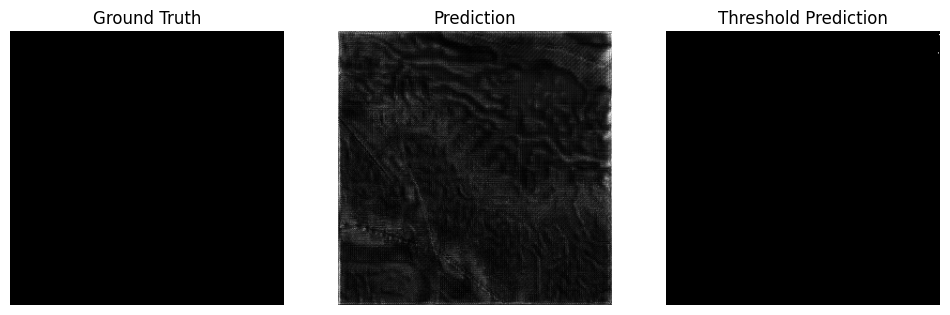

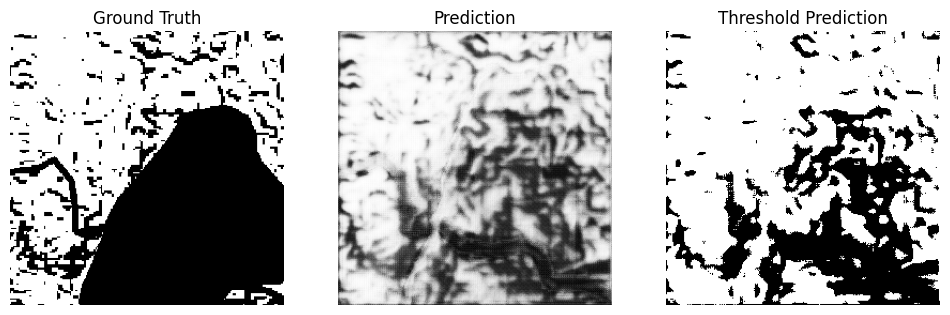

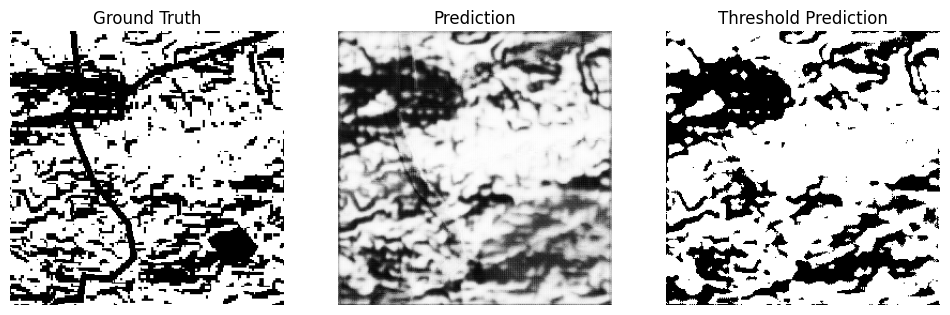

In [ ]:
def plot_images(true_mask, pred_mask,threshold_pred, num=1):
    for i in range(num):
      plt.figure(figsize=(12, 6))
      plt.subplot(1, 3, 1)
      plt.imshow(true_mask[i, :, :, 0], cmap='gray')
      plt.title('Ground Truth')
      plt.axis('off')

      plt.subplot(1, 3, 2)
      plt.imshow(pred_mask[i, :, :, 0], cmap='gray')
      plt.title('Prediction')
      plt.axis('off')

      plt.subplot(1, 3, 3)
      plt.imshow(threshold_pred[i, :, :, 0], cmap='gray')
      plt.title('Threshold Prediction')
      plt.axis('off')

      plt.show()

plot_images(y_test, predictions, threshold_pred, num=20)

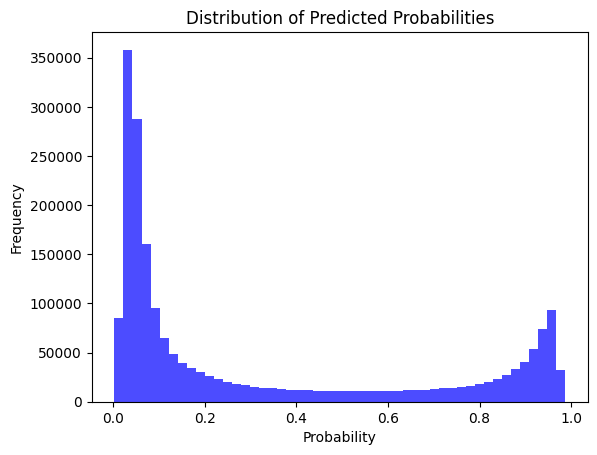

In [ ]:
plt.hist(predictions.flatten(), bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Predicted Probabilities')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.show()

In [ ]:
def plot_images2(test_img, true_mask, pred_mask,threshold_pred, i):

    plt.figure(figsize=(12, 10))

    plt.subplot(3, 4, 1)
    plt.imshow(test_img[i, :, :, 0])  # Display the first channel of the test image
    plt.title('Elec_demand')
    plt.axis('off')

    plt.subplot(3, 4, 2)
    plt.imshow(test_img[i, :, :, 1])  # Display the first channel of the test image
    plt.title('Interest_spot')
    plt.axis('off')

    plt.subplot(3, 4, 3)
    plt.imshow(test_img[i, :, :, 2])  # Display the first channel of the test image
    plt.title('land_pirce')
    plt.axis('off')

    plt.subplot(3, 4, 4)
    plt.imshow(test_img[i, :, :, 3])  # Display the first channel of the test image
    plt.title('nat_env')
    plt.axis('off')

    plt.subplot(3, 4, 5)
    plt.imshow(test_img[i, :, :, 4])  # Display the first channel of the test image
    plt.title('roads')
    plt.axis('off')

    plt.subplot(3, 4, 6)
    plt.imshow(test_img[i, :, :, 5])  # Display the first channel of the test image
    plt.title('Slope')
    plt.axis('off')

    plt.subplot(3, 4, 7)
    plt.imshow(test_img[i, :, :, 6])  # Display the first channel of the test image
    plt.title('trans_line')
    plt.axis('off')

    plt.subplot(3, 4, 8)
    plt.imshow(test_img[i, :, :, 7])  # Display the first channel of the test image
    plt.title('urban')
    plt.axis('off')

    plt.subplot(3, 4, 9)
    plt.imshow(test_img[i, :, :, 8])  # Display the first channel of the test image
    plt.title('wind_speed')
    plt.axis('off')

    plt.subplot(3, 4, 10)
    plt.imshow(true_mask[i, :, :, 0], cmap='gray')
    plt.title('Ground Truth')
    plt.axis('off')

    plt.subplot(3, 4, 11)
    plt.imshow(pred_mask[i, :, :, 0], cmap='gray')
    plt.title('Prediction')
    plt.axis('off')

    plt.subplot(3, 4, 12)
    plt.imshow(threshold_pred[i, :, :, 0], cmap='gray')
    plt.title('Threshold Prediction')
    plt.axis('off')

    plt.show()

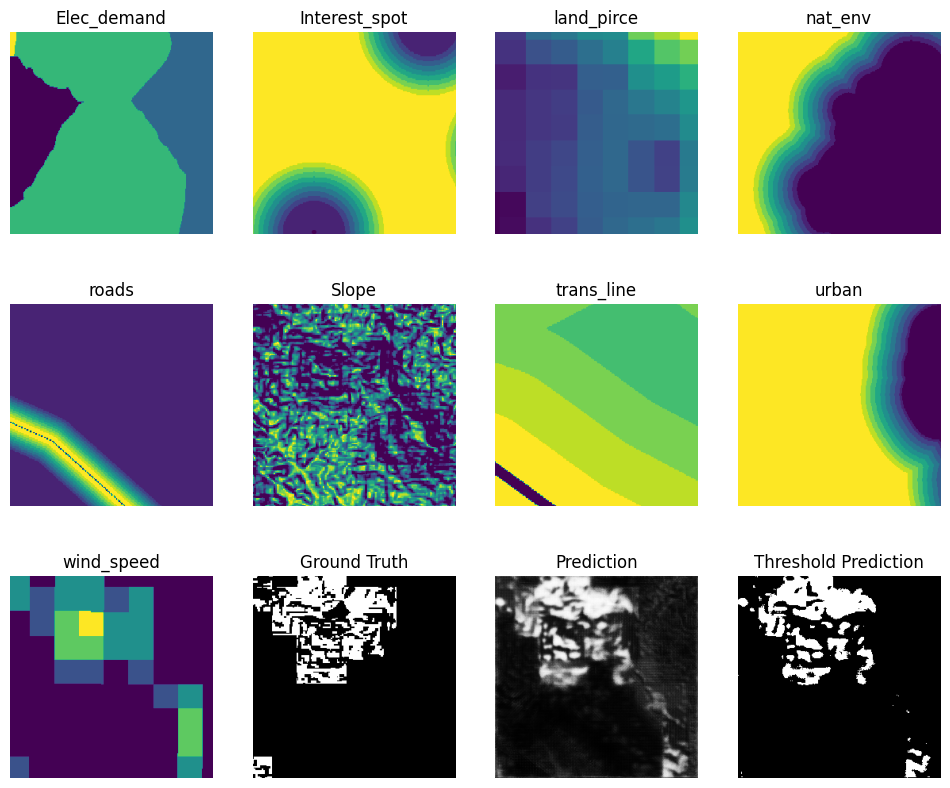

In [ ]:
plot_images2(x_test, y_test, predictions,threshold_pred, 20)

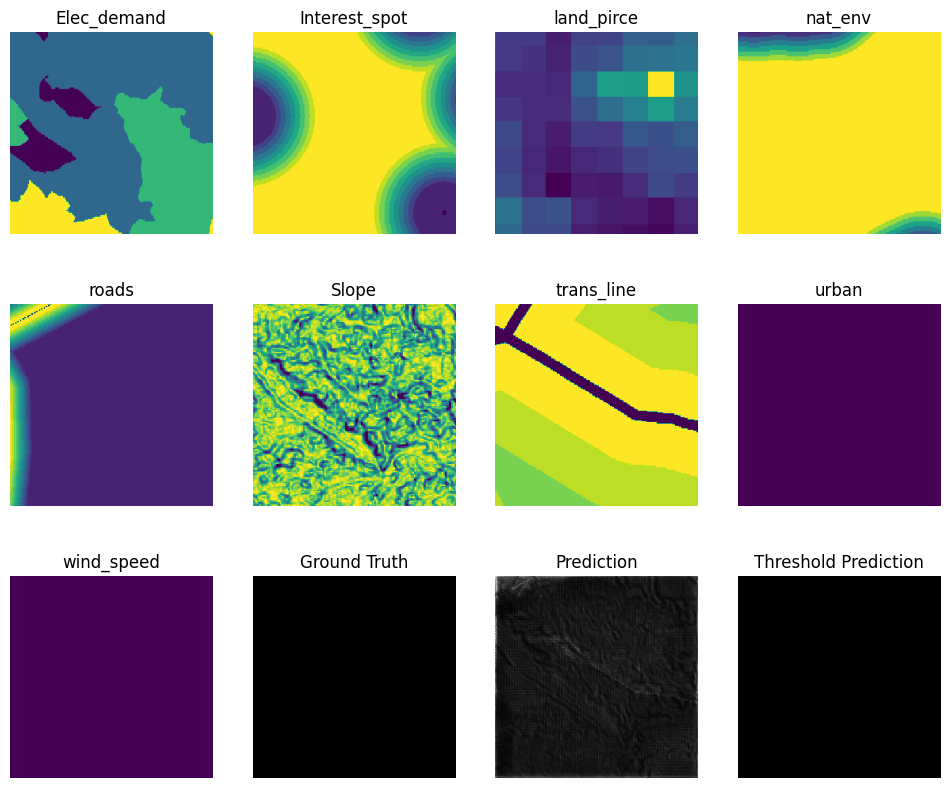

In [ ]:
plot_images2(x_test, y_test, predictions,threshold_pred, 1)

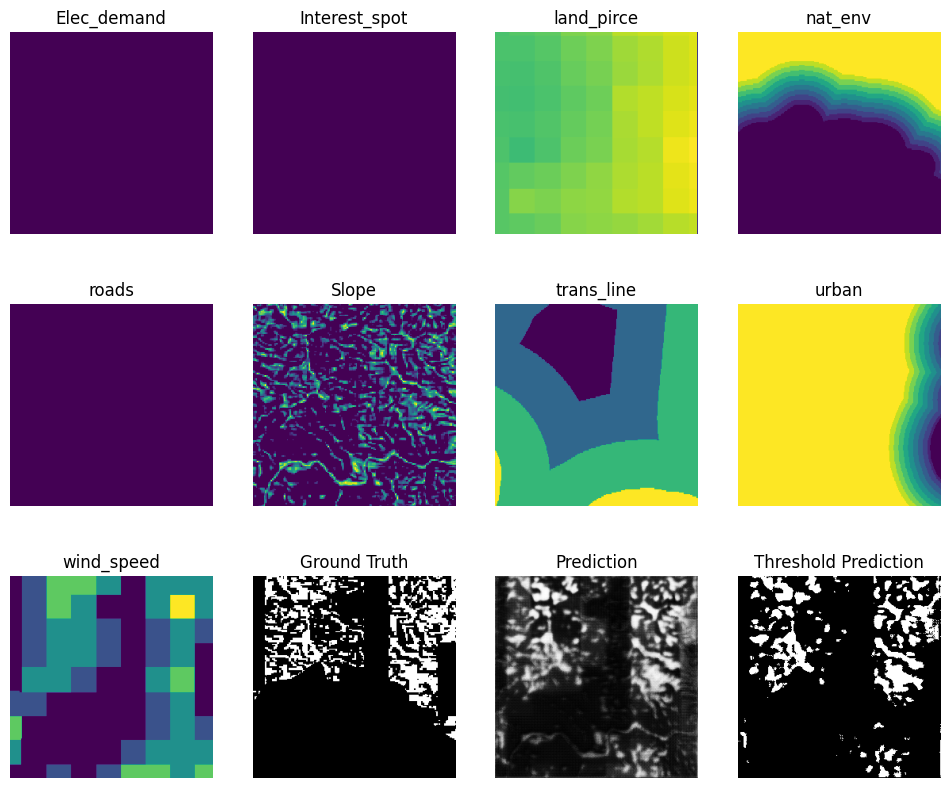

In [ ]:
plot_images2(x_test, y_test, predictions,threshold_pred, 2)

In [ ]:
plot_images2(x_test, y_test, predictions,threshold_pred, 19)

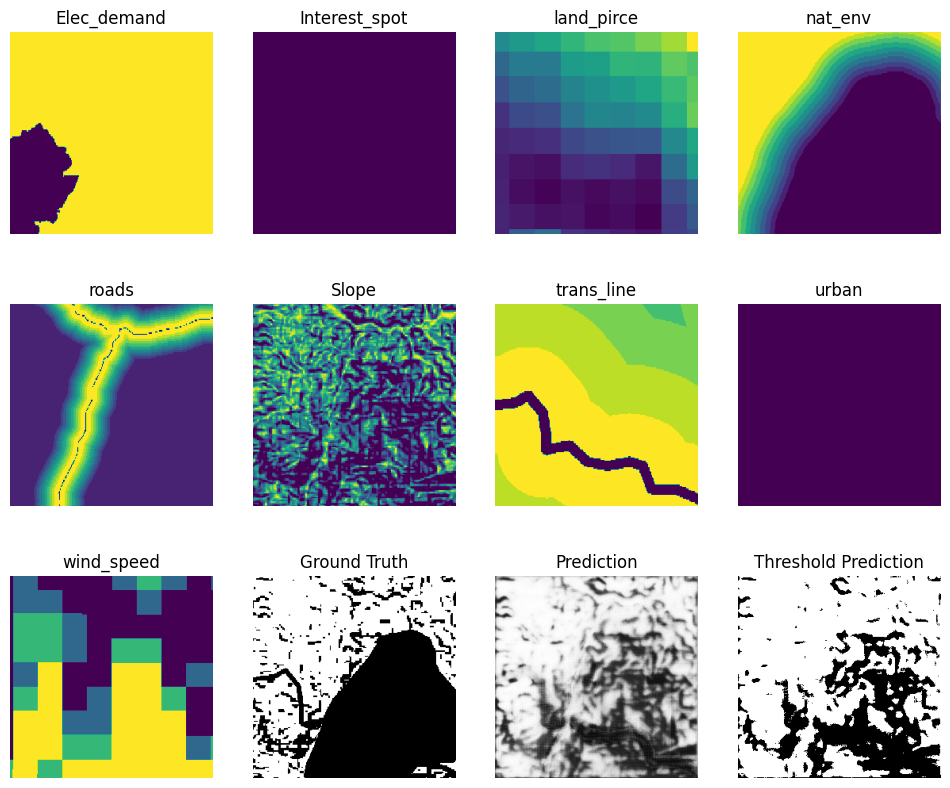

In [ ]:
plot_images2(x_test, y_test, predictions,threshold_pred, 18)

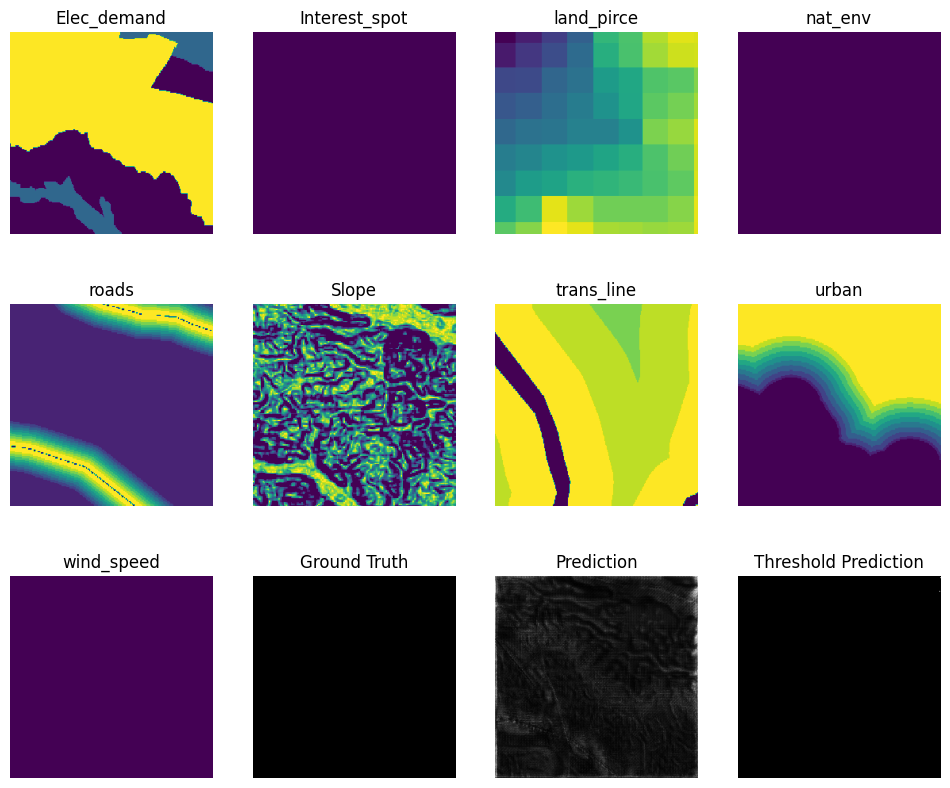

In [ ]:
plot_images2(x_test, y_test, predictions,threshold_pred, 17)

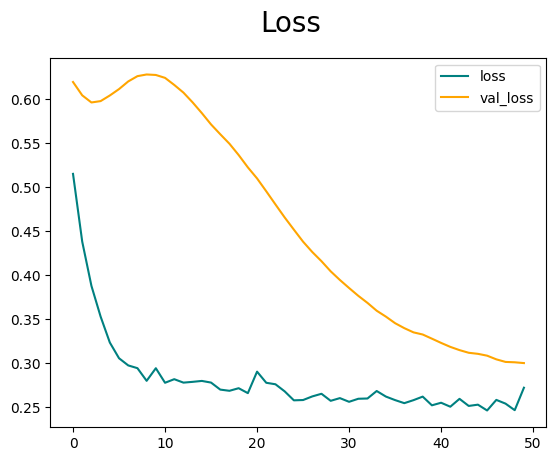

In [ ]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label = 'loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper right')
plt.show()

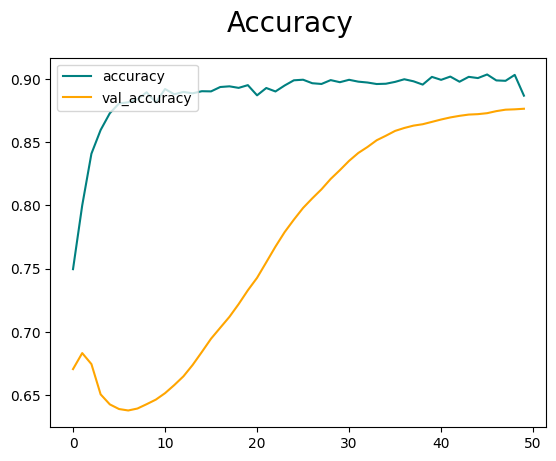

In [ ]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label = 'accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()

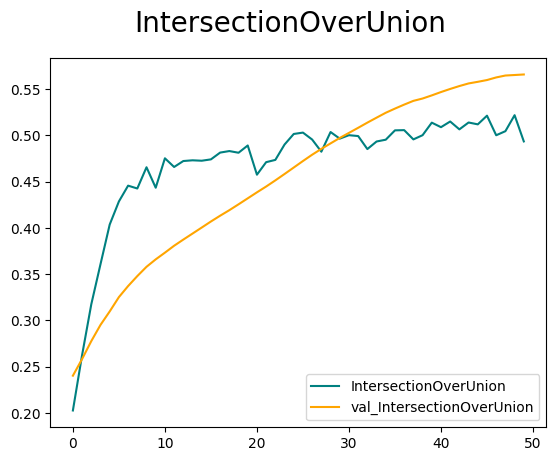

In [ ]:
fig = plt.figure()
plt.plot(history.history['IntersectionOverUnion'], color='teal', label = 'IntersectionOverUnion')
plt.plot(history.history['val_IntersectionOverUnion'], color='orange', label='val_IntersectionOverUnion')
fig.suptitle('IntersectionOverUnion', fontsize=20)
plt.legend(loc='lower right')
plt.show()

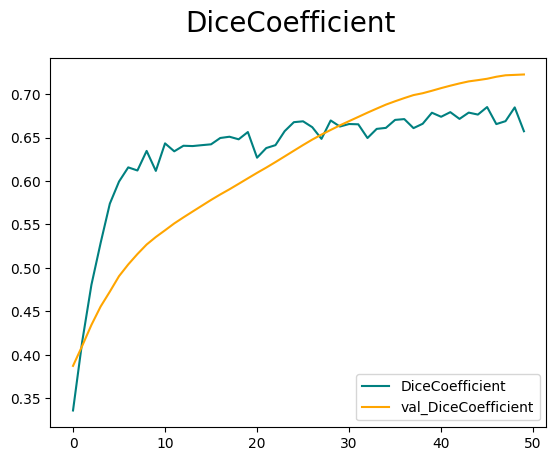

In [ ]:
fig = plt.figure()
plt.plot(history.history['DiceCoefficient'], color='teal', label = 'DiceCoefficient')
plt.plot(history.history['val_DiceCoefficient'], color='orange', label='val_DiceCoefficient')
fig.suptitle('DiceCoefficient', fontsize=20)
plt.legend(loc='lower right')
plt.show()